In [1]:
!pip install requests numpy pandas matplotlib

In [7]:
# 필요한 라이브러리를 불러옵니다.
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

# 그래프의 한글 폰트 깨짐 방지 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
# Mac OS 사용자는 아래 코드를 대신 사용하세요.
# plt.rcParams['font.family'] = 'AppleGothic'

# 그래프의 마이너스 부호 깨짐 방지 설정
plt.rcParams['axes.unicode_minus'] = False

# --- ❗ 중요: 여기에 발급받은 API 키를 입력하세요 ---
API_KEY = "96a80d8f49b4eb1538c2f6ca04f36d3c"

# 데이터를 가져올 위치를 설정합니다. (대한민국 서울 기준)
LATITUDE = 37.5665  # 위도
LONGITUDE = 126.9780 # 경도

print("기본 설정이 완료되었습니다.")

기본 설정이 완료되었습니다.


In [8]:
# '5일/3시간 단위 예보' API URL
forecast_url = f"https://api.openweathermap.org/data/2.5/forecast?lat={LATITUDE}&lon={LONGITUDE}&appid={API_KEY}&units=metric&lang=kr"

# API에 데이터 요청 보내기
response = requests.get(forecast_url)
data = response.json()

# 요청이 성공했는지 확인 (응답 코드 200이면 성공)
if response.status_code == 200:
    print("날씨 예보 데이터를 성공적으로 가져왔습니다.")
else:
    print(f"데이터를 가져오는 데 실패했습니다. 오류 코드: {response.status_code}")
    # print(data) # 오류 메시지를 확인하고 싶을 때 주석 해제

날씨 예보 데이터를 성공적으로 가져왔습니다.


In [11]:
# 3시간 단위 예보 리스트에서 '오늘' 날짜에 해당하는 데이터만 필터링
today_string = str(date.today())
today_forecasts = [item for item in data['list'] if item['dt_txt'].startswith(today_string)]

if today_forecasts:
    # 오늘 예보 데이터 중에서 최고기온과 최저기온을 계산
    today_temp_max = max(item['main']['temp_max'] for item in today_forecasts)
    today_temp_min = min(item['main']['temp_min'] for item in today_forecasts)
    
    # 현재 습도는 가장 가까운 시간대의 예보(리스트의 첫 번째 값)에서 가져옴
    current_humidity = data['list'][0]['main']['humidity']

    print("--- 📝 오늘의 날씨 요약 ---")
    print(f"☀️ 최고기온: {today_temp_max:.1f}°C")
    print(f"🌙 최저기온: {today_temp_min:.1f}°C")
    print(f"💧 현재습도: {current_humidity}%")
else:
    print("오늘의 날씨 정보를 찾을 수 없습니다. API 응답을 확인해주세요.")

--- 📝 오늘의 날씨 요약 ---
☀️ 최고기온: 25.6°C
🌙 최저기온: 19.4°C
💧 현재습도: 45%


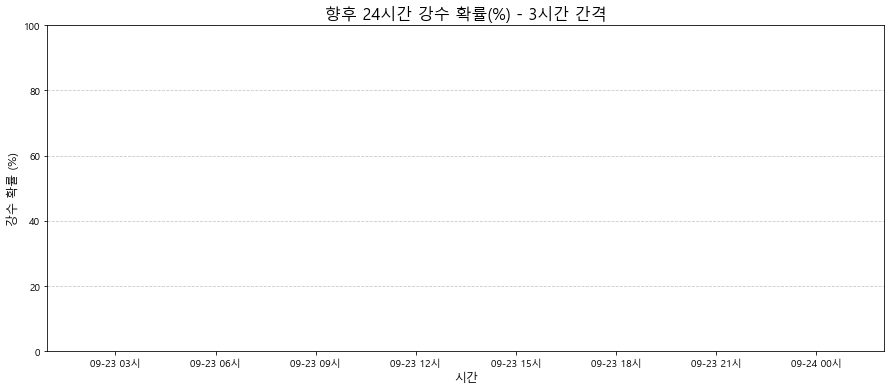

In [12]:
# 전체 예보 리스트를 pandas DataFrame으로 변환하여 다루기 쉽게 만듭니다.
df = pd.DataFrame(data['list'])

# 'dt_txt' (시간정보)를 '월-일 시' 형태로 보기 좋게 바꿉니다.
df['time'] = pd.to_datetime(df['dt_txt']).dt.strftime('%m-%d %H시')

# 강수 확률(pop)은 0~1 사이 값이므로 100을 곱해 퍼센트(%)로 변환합니다.
df['pop'] = df['pop'] * 100

# 향후 24시간(3시간 * 8번)에 해당하는 데이터만 선택합니다.
df_next_24h = df.head(8)

# Matplotlib.pyplot을 사용해 막대 그래프를 그립니다.
plt.figure(figsize=(15, 6)) # 그래프 크기 조절
plt.bar(df_next_24h['time'], df_next_24h['pop'], color='skyblue', width=0.6)

# 그래프 제목과 축 레이블 설정
plt.title('향후 24시간 강수 확률(%) - 3시간 간격', fontsize=16)
plt.xlabel('시간', fontsize=12)
plt.ylabel('강수 확률 (%)', fontsize=12)
plt.ylim(0, 100) # Y축 범위를 0~100으로 고정
plt.grid(axis='y', linestyle='--', alpha=0.7) # 가로 방향 격자 추가

# 그래프를 화면에 표시합니다.
plt.show()

In [13]:
# '대기오염' API URL
air_pollution_url = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={LATITUDE}&lon={LONGITUDE}&appid={API_KEY}"

# API에 데이터 요청 보내기
response_air = requests.get(air_pollution_url)
air_data = response_air.json()

# 미세먼지 데이터 추출 및 출력
if response_air.status_code == 200 and 'list' in air_data:
    aqi = air_data['list'][0]['main']['aqi'] # 통합대기환경지수 (1: 좋음 ~ 5: 매우 나쁨)
    components = air_data['list'][0]['components']
    pm2_5 = components['pm2_5'] # 초미세먼지 (μg/m³)
    pm10 = components['pm10']   # 미세먼지 (μg/m³)

    # AQI 지수에 따른 상태 텍스트
    aqi_status_dict = {1: '좋음', 2: '보통', 3: '보통', 4: '나쁨', 5: '매우 나쁨'}

    print("\n--- 💨 현재 대기질 정보 ---")
    print(f"🔹 통합대기환경지수: {aqi_status_dict.get(aqi, '알 수 없음')} ({aqi}단계)")
    print(f"🔹 미세먼지(PM10): {pm10} μg/m³")
    print(f"🔹 초미세먼지(PM2.5): {pm2_5} μg/m³")
else:
    print("\n대기질 정보를 가져오는 데 실패했습니다.")


--- 💨 현재 대기질 정보 ---
🔹 통합대기환경지수: 보통 (2단계)
🔹 미세먼지(PM10): 9.44 μg/m³
🔹 초미세먼지(PM2.5): 4.84 μg/m³


In [14]:
# 'data' 변수에 날씨 예보 정보가 저장되어 있다고 가정합니다.

# 비가 올 것으로 예상되는 시간대를 저장할 리스트
rainy_hours = []

# 전체 예보 리스트(data['list'])를 확인합니다.
for forecast in data['list']:
    # 강수 확률(pop)을 0~100 사이의 숫자로 변환
    probability = forecast['pop'] * 100
    
    # 날씨 상태 (e.g., 'Rain', 'Clouds', 'Clear')
    weather_status = forecast['weather'][0]['main']
    
    # 시간 정보를 '월-일 시' 형태로 변환
    time = pd.to_datetime(forecast['dt_txt']).strftime('%m-%d %H시')

    # --- 조건: 강수 확률이 50% 이상이고, 날씨가 'Rain'일 경우 ---
    if probability >= 50 and weather_status == 'Rain':
        # 해당 시간과 강수 확률을 튜플 형태로 리스트에 추가
        rainy_hours.append((time, probability))

# 결과 출력
print("--- 🌧️ 오늘 비가 올 가능성이 높은 시간 ---")

if rainy_hours:
    for time, prob in rainy_hours:
        # {prob:.0f}는 소수점 없이 정수로 확률을 표시해줍니다.
        print(f"🕒 {time} 경, 강수 확률: {prob:.0f}%")
else:
    print("향후 예보에 비가 올 가능성이 높은 시간대가 없습니다.")

--- 🌧️ 오늘 비가 올 가능성이 높은 시간 ---
🕒 09-24 03시 경, 강수 확률: 100%
🕒 09-24 06시 경, 강수 확률: 100%
🕒 09-24 09시 경, 강수 확률: 100%
🕒 09-24 12시 경, 강수 확률: 100%
🕒 09-24 15시 경, 강수 확률: 100%
🕒 09-27 21시 경, 강수 확률: 53%
🕒 09-28 00시 경, 강수 확률: 100%
